In [24]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_non_normalized, y_train_non_normalized = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [25]:
print(X_train_non_normalized.shape)
print(y_train_non_normalized.shape)
print(X_test.shape)
print(y_test.shape)

(34799, 32, 32, 3)
(34799,)
(12630, 32, 32, 3)
(12630,)


In [26]:
from sklearn.model_selection import train_test_split

X_train_non_normalized, X_validation, y_train_non_normalized, y_validation = train_test_split(X_train_non_normalized, y_train_non_normalized, test_size=0.2, random_state=0)

print("Updated Image Shape: {}".format(X_train_non_normalized[0].shape))

Updated Image Shape: (32, 32, 3)


In [27]:
print(X_train_non_normalized.shape)
print(y_train_non_normalized.shape)
print(X_validation.shape)
print(y_validation.shape)

(27839, 32, 32, 3)
(27839,)
(6960, 32, 32, 3)
(6960,)


In [28]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

X_train = []
y_train = []
for i, (image, label) in enumerate(zip(X_train_non_normalized, y_train_non_normalized)):
    zeros = np.zeros((32,32,3))
    norm_image = cv2.normalize(image, zeros, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #rows, cols, depth = norm_image.shape
    #center = (cols/2, rows/2)
    #M_90 = cv2.getRotationMatrix2D(center, 90, 1)
    #rotated_90 = cv2.warpAffine(norm_image, M_90, (cols,rows))
    X_train.append(norm_image)
    y_train.append(label)
    #X_train.append(rotated_90)
    #y_train.append(label)

(32, 32, 3)
177


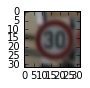

In [19]:
plt.figure(figsize=(2,1))
plt.imshow(image)
print(image.shape)
print(np.max(image))



(32, 32, 3)
1.0


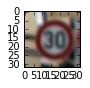

In [20]:
plt.figure(figsize=(2,1))
plt.imshow(norm_image)
print(norm_image.shape)
print(np.max(norm_image))

(32, 32, 3)
1.0


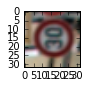

In [21]:
plt.figure(figsize=(2,1))
plt.imshow(rotated_90)
print(rotated_90.shape)
print(np.max(rotated_90))

In [29]:
print(len(X_train))

27839


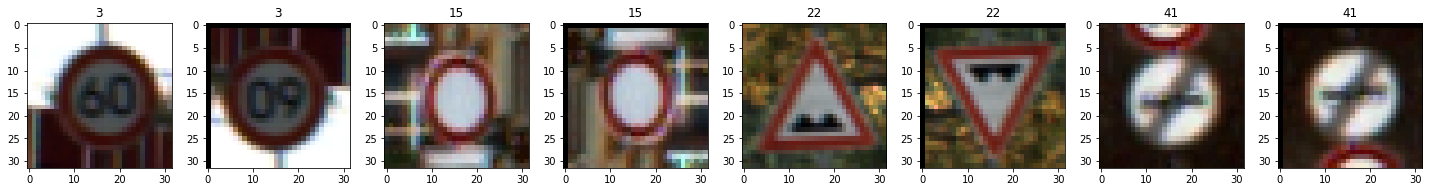

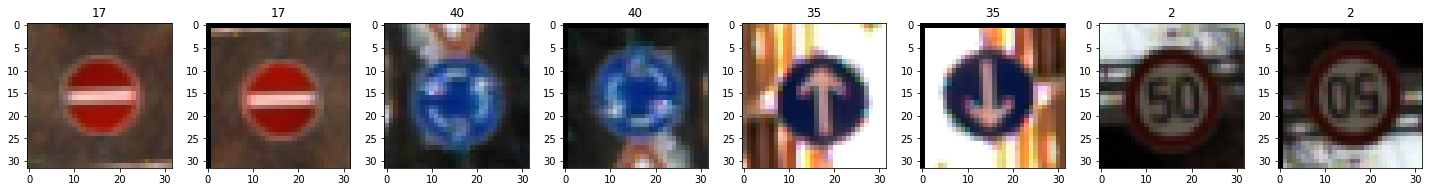

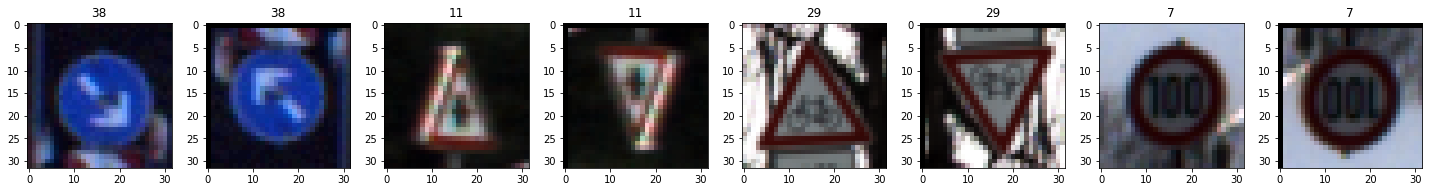

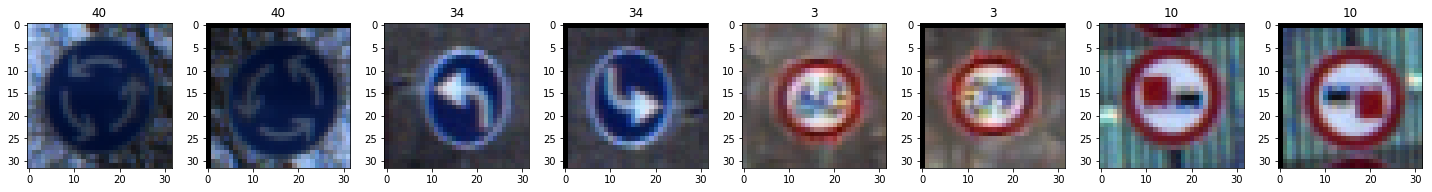

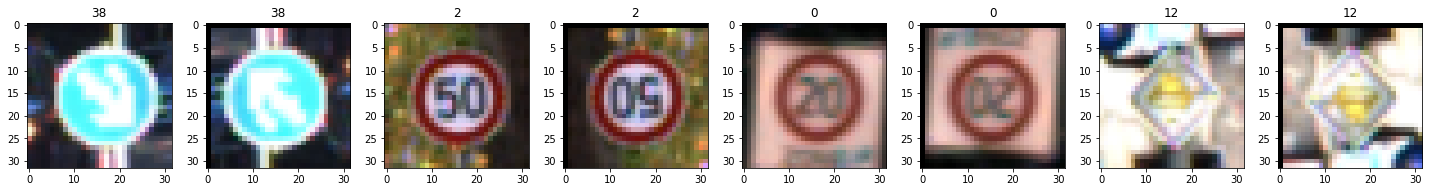

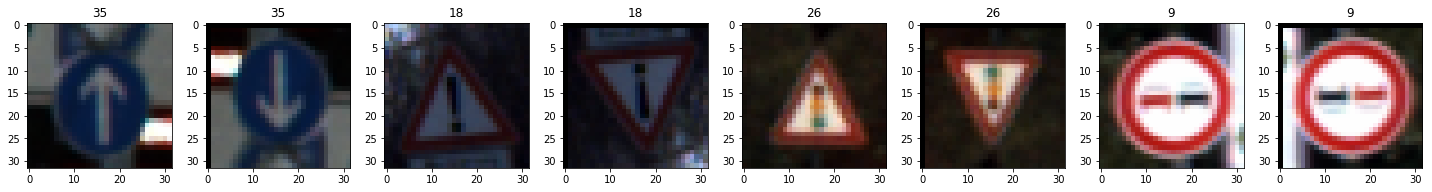

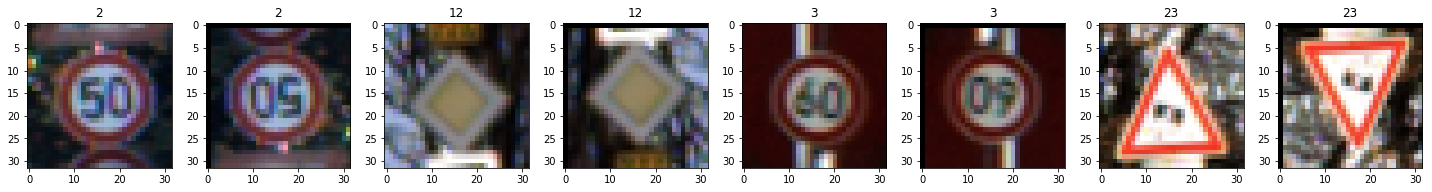

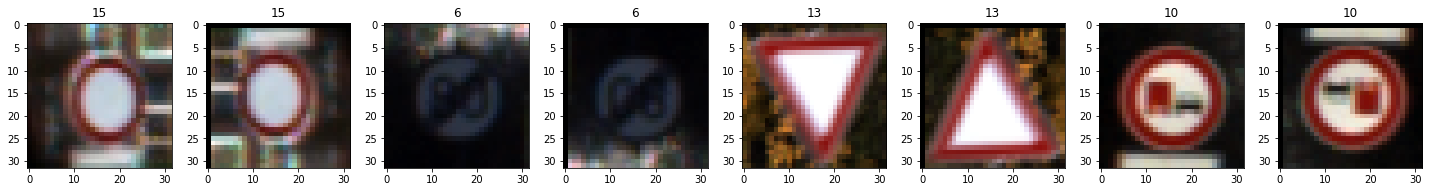

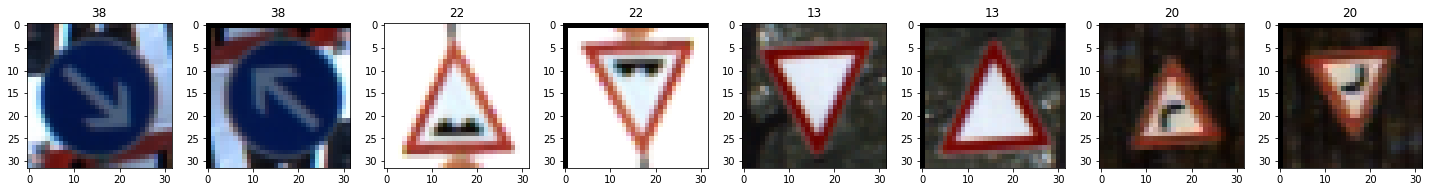

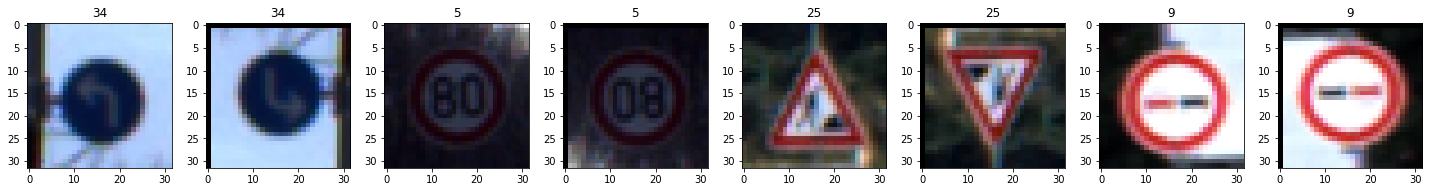

In [10]:
import random

mini_batch_size = 8
for start in range(0, 80, mini_batch_size): 
    fig, axes = plt.subplots(1,mini_batch_size)
    end = start+mini_batch_size
    for i, ((image, ax), label) in enumerate(zip(zip(X_train[start:end], axes), y_train[start:end])):
        ax.set_title(label)
        ax.imshow(image.squeeze())

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [30]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [31]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1  = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [32]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) 
one_hot_y = tf.one_hot(y, 43)

In [34]:
rate = 0.001
EPOCHS = 100
BATCH_SIZE = 128

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [35]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [36]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.479

EPOCH 2 ...
Validation Accuracy = 0.707

EPOCH 3 ...
Validation Accuracy = 0.780

EPOCH 4 ...
Validation Accuracy = 0.836

EPOCH 5 ...
Validation Accuracy = 0.864

EPOCH 6 ...
Validation Accuracy = 0.910

EPOCH 7 ...
Validation Accuracy = 0.928

EPOCH 8 ...
Validation Accuracy = 0.917

EPOCH 9 ...
Validation Accuracy = 0.935

EPOCH 10 ...
Validation Accuracy = 0.930

EPOCH 11 ...
Validation Accuracy = 0.954

EPOCH 12 ...
Validation Accuracy = 0.944

EPOCH 13 ...
Validation Accuracy = 0.961

EPOCH 14 ...
Validation Accuracy = 0.949

EPOCH 15 ...
Validation Accuracy = 0.967

EPOCH 16 ...
Validation Accuracy = 0.963

EPOCH 17 ...
Validation Accuracy = 0.966

EPOCH 18 ...
Validation Accuracy = 0.943

EPOCH 19 ...
Validation Accuracy = 0.966

EPOCH 20 ...
Validation Accuracy = 0.974

EPOCH 21 ...
Validation Accuracy = 0.968

EPOCH 22 ...
Validation Accuracy = 0.968

EPOCH 23 ...
Validation Accuracy = 0.959

EPOCH 24 ...
Validation Accura

In [37]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.927


In [21]:
rate = 0.0001
EPOCHS = 200
BATCH_SIZE = 128

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [22]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x8.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 8), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(8))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x8. Output = 14x14x8.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x20.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 8, 20), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(20))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x20. Output = 5x5x20.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x20. Output = 500.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 500. Output = 250.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(500, 250), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(250))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1  = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 250. Output = 125.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(250, 125), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(125))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 125, Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(125, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.011

EPOCH 2 ...
Validation Accuracy = 0.011

EPOCH 3 ...
Validation Accuracy = 0.011

EPOCH 4 ...
Validation Accuracy = 0.011

EPOCH 5 ...
Validation Accuracy = 0.011

EPOCH 6 ...
Validation Accuracy = 0.011

EPOCH 7 ...
Validation Accuracy = 0.011

EPOCH 8 ...
Validation Accuracy = 0.011

EPOCH 9 ...
Validation Accuracy = 0.011

EPOCH 10 ...
Validation Accuracy = 0.011

EPOCH 11 ...
Validation Accuracy = 0.011

EPOCH 12 ...
Validation Accuracy = 0.011

EPOCH 13 ...
Validation Accuracy = 0.011

EPOCH 14 ...
Validation Accuracy = 0.011

EPOCH 15 ...
Validation Accuracy = 0.011

EPOCH 16 ...
Validation Accuracy = 0.011

EPOCH 17 ...
Validation Accuracy = 0.011

EPOCH 18 ...
Validation Accuracy = 0.011

EPOCH 19 ...
Validation Accuracy = 0.011

EPOCH 20 ...
Validation Accuracy = 0.011

EPOCH 21 ...
Validation Accuracy = 0.011

EPOCH 22 ...
Validation Accuracy = 0.011

EPOCH 23 ...
Validation Accuracy = 0.011

EPOCH 24 ...
Validation Accura

KeyboardInterrupt: 